In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
df = pd.read_excel("Bloomberg Data.xlsx")

In [3]:

df.columns = [
    'Date_Bitcoin', 'Bitcoin_Price', 'Date_Gold', 'Gold_Price',
    'Date_Oil', 'Oil_Price', 'Date_Treasury', 'Treasury_Yield',
    'Date_SPX', 'SPX_Price', 'Date_NASDAQ', 'NASDAQ_Price',
    'Date_Dollar_Index', 'Dollar_Index', 'Date_Fed_Funds', 'Fed_Funds_Rate'
]


df = df.iloc[2:]


date_columns = [col for col in df.columns if 'Date' in col]
for col in date_columns:
    df[col] = pd.to_datetime(df[col])

df_bitcoin = df[['Date_Bitcoin', 'Bitcoin_Price']].dropna().rename(columns={'Date_Bitcoin': 'Date'})
df_gold = df[['Date_Gold', 'Gold_Price']].dropna().rename(columns={'Date_Gold': 'Date'})
df_oil = df[['Date_Oil', 'Oil_Price']].dropna().rename(columns={'Date_Oil': 'Date'})
df_treasury = df[['Date_Treasury', 'Treasury_Yield']].dropna().rename(columns={'Date_Treasury': 'Date'})
df_spx = df[['Date_SPX', 'SPX_Price']].dropna().rename(columns={'Date_SPX': 'Date'})
df_nasdaq = df[['Date_NASDAQ', 'NASDAQ_Price']].dropna().rename(columns={'Date_NASDAQ': 'Date'})
df_dollar_index = df[['Date_Dollar_Index', 'Dollar_Index']].dropna().rename(columns={'Date_Dollar_Index': 'Date'})
df_fed_funds = df[['Date_Fed_Funds', 'Fed_Funds_Rate']].dropna().rename(columns={'Date_Fed_Funds': 'Date'})

In [10]:
df.head()

,Date_Bitcoin,Bitcoin_Price,Date_Gold,Gold_Price,Date_Oil,Oil_Price,Date_Treasury,Treasury_Yield,Date_SPX,SPX_Price,Date_NASDAQ,NASDAQ_Price,Date_Dollar_Index,Dollar_Index,Date_Fed_Funds,Fed_Funds_Rate
2,2020-01-02,6960.58,2020-01-02,1529.13,2020-01-03,63.05,2020-01-03,105.554,2020-01-03,3234.85,2020-01-03,9020.77,2020-01-02,96.846,2020-01-03,1.55
3,2020-01-03,7269.82,2020-01-03,1552.2,2020-01-06,63.27,2020-01-06,105.4392,2020-01-06,3246.28,2020-01-06,9071.47,2020-01-03,96.838,2020-01-06,1.55
4,2020-01-05,7363.55,2020-01-06,1565.74,2020-01-07,62.7,2020-01-07,105.3628,2020-01-07,3237.18,2020-01-07,9068.58,2020-01-06,96.671,2020-01-07,1.55
5,2020-01-06,7575.93,2020-01-07,1574.37,2020-01-08,1,2020-01-08,105.0441,2020-01-08,3253.05,2020-01-08,9129.24,2020-01-07,97.005,2020-01-08,1.55
6,2020-01-07,8021.36,2020-01-08,1556.42,2020-01-09,59.56,2020-01-09,105.1461,2020-01-09,3274.7,2020-01-09,9203.43,2020-01-08,97.299,2020-01-09,1.55


## Gold VS Bitcoin

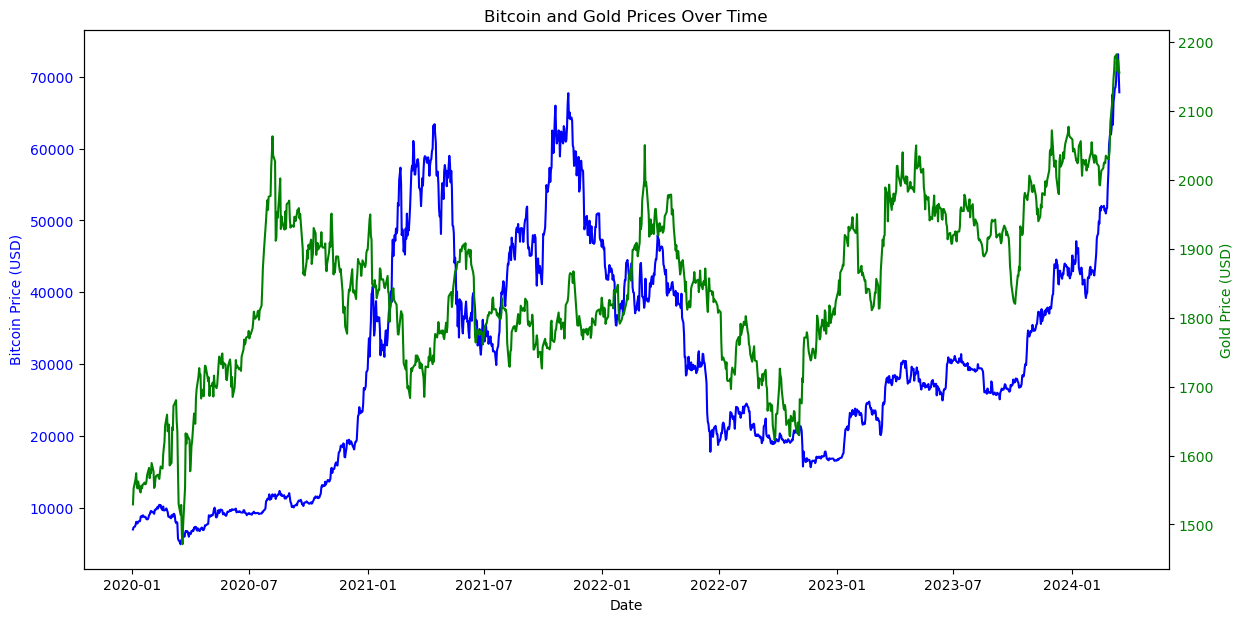

In [23]:
date_bit = df_bitcoin['Date']
bit_price = df_bitcoin['Bitcoin_Price']
date_gold = df_gold['Date']
gold_price = pd.to_numeric(df_gold['Gold_Price'], errors='coerce')

fig, ax1 = plt.subplots(figsize=(14, 7))
# Bitcoin price plot
color = 'blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Bitcoin Price (USD)', color=color)
ax1.plot(date_bit, bit_price, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()

# Gold price plot
color2 = 'green'
ax2.set_ylabel('Gold Price (USD)', color=color2)
ax2.plot(date_gold, gold_price, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Title and labels
plt.title('Bitcoin and Gold Prices Over Time')
plt.show()

## SP500 VS Bitcoin

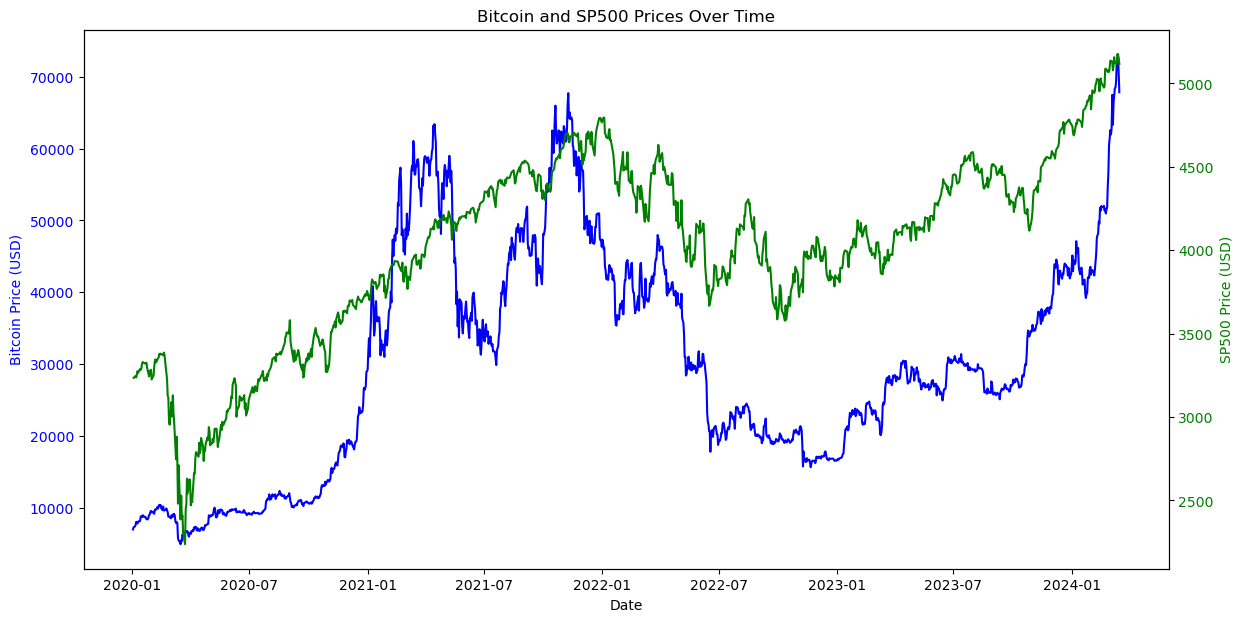

In [24]:
date_bit = df_bitcoin['Date']
bit_price = df_bitcoin['Bitcoin_Price']
date_sp = df_spx['Date']
sp_price = pd.to_numeric(df_spx['SPX_Price'])

fig, ax1 = plt.subplots(figsize=(14, 7))
# Bitcoin price plot
color = 'blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Bitcoin Price (USD)', color=color)
ax1.plot(date_bit, bit_price, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()

# Gold price plot
color2 = 'green'
ax2.set_ylabel('SP500 Price (USD)', color=color2)
ax2.plot(date_sp, sp_price, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Title and labels
plt.title('Bitcoin and SP500 Prices Over Time')
plt.show()

### Inital Model Build

In [12]:
df_changes = pd.DataFrame()
for col in df.columns:
    if 'Price' in col:
        asset_name = col.split('_')[0]
        df_changes[f'{asset_name}_Change'] = df[col].diff()  # calculate the price change from the previous day

# 2. Take the log of the absolute change plus 1 for numerical columns
numerical_cols = df_changes.select_dtypes(include=[np.number]).columns
df_changes[numerical_cols] = np.log(df_changes[numerical_cols].abs() + 1)

# Add date column
df_changes['Date'] = df['Date_Bitcoin'].iloc[1:]

# Drop the first row since it will have NaN values due to differencing
df_changes = df_changes.dropna()

# Convert all columns to numerical type
df_changes = df_changes.apply(pd.to_numeric, errors='coerce')

# Remove rows with NaN values
df_changes = df_changes.dropna()

# 3. Build a regression model
X = df_changes[['Gold_Change', 'Oil_Change',  'SPX_Change', 'NASDAQ_Change']]
y = df_changes['Bitcoin_Change']

X = sm.add_constant(X)  # Add constant for the intercept term

model = sm.OLS(y, X)
results = model.fit()

# 4. Test the T p-value for the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Bitcoin_Change   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9436
Date:                Wed, 20 Mar 2024   Prob (F-statistic):              0.438
Time:                        20:23:39   Log-Likelihood:                -9051.8
No. Observations:                1056   AIC:                         1.811e+04
Df Residuals:                    1051   BIC:                         1.814e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.5330     39.454      0.166

Index(['Date_Bitcoin', 'Bitcoin_Price', 'Date_Gold', 'Gold_Price', 'Date_Oil',
       'Oil_Price', 'Date_Treasury', 'Treasury_Yield', 'Date_SPX', 'SPX_Price',
       'Date_NASDAQ', 'NASDAQ_Price', 'Date_Dollar_Index', 'Dollar_Index',
       'Date_Fed_Funds', 'Fed_Funds_Rate'],
      dtype='object')